### Objective 

Our goal is to examine the data from Relax Inc., a highly funded startup based in San Francisco that makes productivity and project management software, and use the data to 
* define an "adopted user" as one who has logged into the product on 3 separate days  in at least 1 seven-day period
* identify which factors predict future user adoption 
* brief writeup of analysis and any ideas for further research

In [2]:
# Import necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Remove deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the first dataset "users" with latin encoding since there were errors without encoding
users = pd.read_csv('data/takehome_users.csv', encoding='latin')
# Remove scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00,8823.00,12000.00,12000.00,12000.00,6417.00
mean,6000.50,1379279305.70,0.25,0.15,141.88,5962.96
std,3464.25,19531160.79,0.43,0.36,124.06,3383.76
min,1.00,1338452406.00,0.00,0.00,0.00,3.00
25%,3000.75,1363194965.00,0.00,0.00,29.00,3058.00
50%,6000.50,1382888470.00,0.00,0.00,108.00,5954.00
75%,9000.25,1398442604.00,0.00,0.00,238.25,8817.00
max,12000.00,1402066730.00,1.00,1.00,416.00,11999.00


In [7]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.00,1,0,11,10803.00
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.00,0,0,1,316.00
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892.00,0,0,94,1525.00
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168.00,0,0,1,5151.00
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660.00,0,0,193,5240.00


We see above that the last_session_creation_time column is not a datetime object and that there are much fewer data in this column. There are also significant missing values in the invited_by_user_id column. 

Data of 12,000 users who signed up for Relax Inc.'s product in last 2 years
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
    * PERSONAL_PROJECTS: invited to join another user's personal workspace
    * GUEST_INVITE: invited to an organization as a guest (limited permissions)
    * ORG_INVITE: invited to an organization (as a full member)
    * SIGNUP: signed up via the website
    * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).

In [9]:
# Load user engagement data
engagement = pd.read_csv('data/takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


The engagement data has no missing values and contain visited data for each user with a time_stamp on each row of the 207,917 entries. 

### Defining adopted users

After our brief EDA analysis we will use our engagement data to engineer a new feature called "adopted users" based on if they have logged into the product on three separate days in at least one seven-day period. 

In [11]:
# How many values does 'visited' take?
sorted(list(engagement['visited'].unique()))

[1]

In [12]:
# Count how many unique users in our engagment data of the 207,917 entries 
print('There are {} unique users of the 207,917 entries in engagement data'\
      .format(len(engagement['user_id'].unique())))

There are 8823 unique users of the 207,917 entries in engagement data


In [13]:
# Narrowing down users who logged in 3 times in total
three_logins = engagement.groupby('user_id').filter(lambda x: len(x) >=3)
print('There are {} unique users who logged in 3 times or more in total'\
      .format(len(three_logins['user_id'].unique())))

three_logins.head(2)

There are 2248 unique users who logged in 3 times or more in total


,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [14]:
# Remove index
three_logins.reset_index(drop=True, inplace = True)

# Finding how many of the 2248 unique three-logins users are adopted users 
# who have logged in three separate days in at least one 7 day period 

adopted = 0
adopted_users = []
for i in range(len(three_logins)-2):
    user = three_logins['user_id'][i]
    if user != adopted and user == three_logins['user_id'][i+2]:
    # Get start date 
        sd = pd.Timestamp(three_logins['time_stamp'][i])
        # 7 days period end date
        ed = sd + pd.Timedelta('7D')
        if sd < pd.Timestamp(three_logins['time_stamp'][i+1]) < ed and sd < \
        pd.Timestamp(three_logins['time_stamp'][i+2]) < ed:
            adopted_users.append(user)
            adopted = user

In [15]:
# Count how many adopted users there are 
len(adopted_users)

1602

In [16]:
# Add our new adopted_users feature to users dataframe: 1 for adopted and 0 for not-adopted

y = pd.Series(np.random.randn(len(users)))
n = 0
for i in range(len(users)):
    if users['object_id'][i] == adopted_users[n]:
        y[i] = 1
        n = n+1
        if n > len(adopted_users)-1:
            n = n -1
    else:
        y[i] = 0
        
users2 = pd.DataFrame(y, columns = ['adopted_users'])
df = pd.concat([users, users2], axis=1)
print((df[df['adopted_users'] == 1]).count())

object_id                     1602
creation_time                 1602
name                          1602
email                         1602
creation_source               1602
last_session_creation_time    1602
opted_in_to_mailing_list      1602
enabled_for_marketing_drip    1602
org_id                        1602
invited_by_user_id             913
adopted_users                 1602
dtype: int64


In [17]:
# We see above that some users were not invited by another user
# Construct another feature of invited: 1 for invited and 0 for wasn't invited 
inv = pd.Series(np.random.randn(len(df)))
for i in range(len(df)):
    if df['invited_by_user_id'][i] >=1:
        inv[i] = 1
    else:
        inv[i] = 0
df2 = pd.DataFrame(inv, columns = ['invited'])
df3 = pd.concat([df,df2], axis = 1)

In [18]:
df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.00,1,0,11,10803.00,0.00
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.00,0,0,1,316.00,1.00


In [19]:
df3.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.00,1,0,11,10803.00,0.00,1.00
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.00,0,0,1,316.00,1.00,1.00


### Predictive Modeling

After defining our adopted users, we will now aim to identify which factors predict future users adoption using a classification machine learning model. 

In [20]:
# We will first use one-hot encoding to transform our categorical features 
df3['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH'])

LabelEncoder()

In [22]:
creation = le.transform(df['creation_source'])

In [23]:
df4 = pd.DataFrame(creation, columns = ['creation'])
df = pd.concat([df3 ,df4], axis=1)
df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,invited,creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.00,1,0,11,10803.00,0.00,1.00,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.00,0,0,1,316.00,1.00,1.00,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892.00,0,0,94,1525.00,0.00,1.00,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168.00,0,0,1,5151.00,0.00,1.00,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660.00,0,0,193,5240.00,0.00,1.00,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1387424226.00,0,0,197,11241.00,0.00,1.00,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1356009872.00,0,1,37,nan,0.00,0.00,3
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,nan,1,1,74,nan,0.00,0.00,2
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,nan,0,0,302,nan,0.00,0.00,2
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1401833283.00,1,1,318,4143.00,1.00,1.00,1


In [24]:
# Import Extreme Gradient Boosting Classification Model 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create axes for labels and features
y = df['adopted_users']
X = df[['creation','last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [25]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
X.columns

Index(['creation', 'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id'],
      dtype='object')

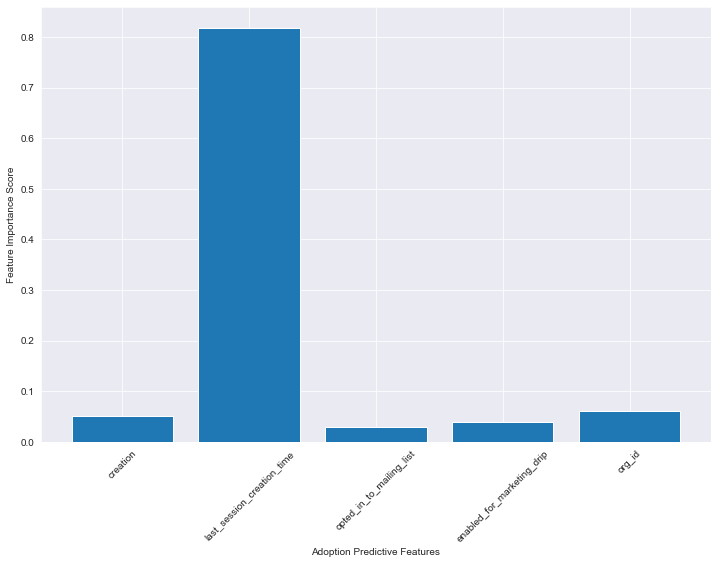

In [27]:
# Plot the feature importances for our target label of adopted users 
feat_imp = model.feature_importances_
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
xcol = X.columns
plt.xlabel('Adoption Predictive Features')
plt.ylabel('Feature Importance Score')
plt.xticks(range(len(xcol)), xcol.values, rotation=45)
plt.show()

In [28]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.97%


We see above that the XGBClassifier model does a good job in predicting whether a user will be an adopted user in the future and that the two most important features to determine adoption are the last login times of a user and the organization the users belong to. 